<a href="https://colab.research.google.com/github/SupreethRao99/Kaggle/blob/master/Rock_Paper_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today we shall tackle the [rock-paper-scissor](https://www.kaggle.com/drgfreeman/rockpaperscissors/notebooks) dataset from kaggle. the dataset consists of 2188 images of human hands on green backgrounds making hand signs of rock, paper and scissor. We aim to create a multi-class classifier that correctly predicts what symbol the person has shown.

let us first install all the necessary libraries and set up a pipeline through which we can directly load datasets from [Kaggle](https://kaggle.com).

In [ ]:
!pip install kaggle
from google.colab import files
import os
files.upload()

let us now directly load the dataset from kaggle into a directory called `kaggle`

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d drgfreeman/rockpaperscissors

 99% 302M/306M [00:13<00:00, 24.2MB/s]
100% 306M/306M [00:13<00:00, 23.9MB/s]


Let us now unzip the file into the `/tmp` directory

In [1]:
import zipfile
zip_ref = zipfile.ZipFile('rockpaperscissors.zip','r')
zip_ref.extractall('/tmp')
zip_ref.close()

let us now preprocess our images where we create our training samples and validation samples as well as augment the images to further improve our training accuracy.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TRAIN_DIR = '/tmp/rps-cv-images/'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(60,40),
                                                    subset='training'
                                                  )

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

validation_generator = validation_datagen.flow_from_directory(TRAIN_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(60,40),
                                                              subset='validation')

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


# A barebones convolutional neural network

In [4]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(60,40,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3,activation='softmax')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 36, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 18, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 9, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 9, 128)        73856     
_________________________________________________________________
flatten (Flatten)            (None, 16128)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16128)             0

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs=25,validation_data= validation_generator)

Epoch 1/25
55/55 [==============================] - 6s 100ms/step - loss: 1.0978 - accuracy: 0.3524 - val_loss: 1.0049 - val_accuracy: 0.5812
Epoch 2/25
55/55 [==============================] - 5s 98ms/step - loss: 0.9405 - accuracy: 0.5431 - val_loss: 0.6177 - val_accuracy: 0.7529
Epoch 3/25
55/55 [==============================] - 5s 96ms/step - loss: 0.7300 - accuracy: 0.6836 - val_loss: 0.6221 - val_accuracy: 0.7185
Epoch 4/25
55/55 [==============================] - 5s 96ms/step - loss: 0.6326 - accuracy: 0.7533 - val_loss: 0.3285 - val_accuracy: 0.8902
Epoch 5/25
55/55 [==============================] - 5s 96ms/step - loss: 0.4845 - accuracy: 0.8144 - val_loss: 0.1667 - val_accuracy: 0.9611
Epoch 6/25
55/55 [==============================] - 5s 96ms/step - loss: 0.3853 - accuracy: 0.8612 - val_loss: 0.1612 - val_accuracy: 0.9611
Epoch 7/25
55/55 [==============================] - 5s 96ms/step - loss: 0.3012 - accuracy: 0.8989 - val_loss: 0.0830 - val_accuracy: 0.9725
Epoch 8/25
5

Text(0.5, 1.0, 'Training and validation loss')

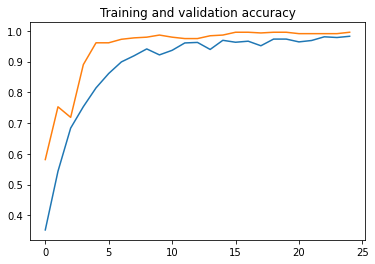

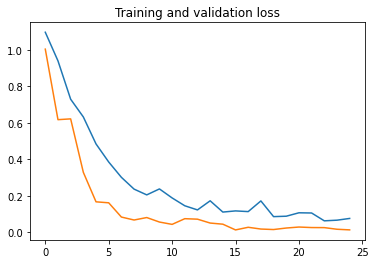

In [7]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
## Training and Validation Accuracy
epochs   = range(len(acc))
plt.plot  (epochs, acc)
plt.plot  (epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()
## Training and Validation loss
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss')

Let us apply performance scheduling to the same model and see the results 

In [8]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.000001)

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

history = model.fit(train_generator,
                    epochs = 25,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction])

Epoch 1/25
55/55 [==============================] - 5s 99ms/step - loss: 0.1222 - acc: 0.9566 - val_loss: 0.0188 - val_acc: 0.9931
Epoch 2/25
55/55 [==============================] - 5s 95ms/step - loss: 0.1027 - acc: 0.9686 - val_loss: 0.0129 - val_acc: 0.9954
Epoch 3/25
55/55 [==============================] - 5s 95ms/step - loss: 0.0755 - acc: 0.9817 - val_loss: 0.0100 - val_acc: 0.9954
Epoch 4/25
55/55 [==============================] - 5s 96ms/step - loss: 0.0855 - acc: 0.9777 - val_loss: 0.1526 - val_acc: 0.9497
Epoch 5/25
55/55 [==============================] - 5s 96ms/step - loss: 0.0563 - acc: 0.9817 - val_loss: 0.0103 - val_acc: 0.9954
Epoch 6/25
55/55 [==============================] - 5s 96ms/step - loss: 0.0632 - acc: 0.9852 - val_loss: 0.0093 - val_acc: 0.9977
Epoch 7/25
55/55 [==============================] - 5s 96ms/step - loss: 0.0582 - acc: 0.9863 - val_loss: 0.0367 - val_acc: 0.9931
Epoch 8/25
55/55 [==============================] - 5s 96ms/step - loss: 0.0725 - a

Text(0.5, 1.0, 'Training and validation loss')

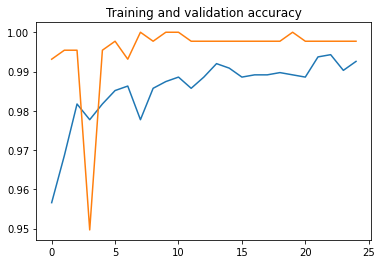

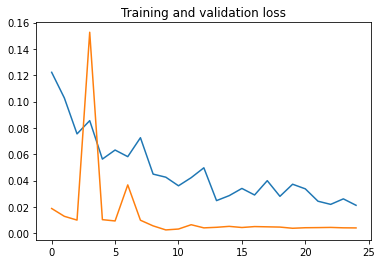

In [10]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
## Training and Validation Accuracy
epochs   = range(len(acc))
plt.plot  (epochs, acc)
plt.plot  (epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()
## Training and Validation loss
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss')

Let us now use the ResNet-34 model architecture on this problem

# ResNet-34

In [11]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [12]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 20, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 20, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 30, 20, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 10, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 15, 10, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 15, 10, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 8, 5, 128)         2

Text(0.5, 1.0, 'Training and validation loss')

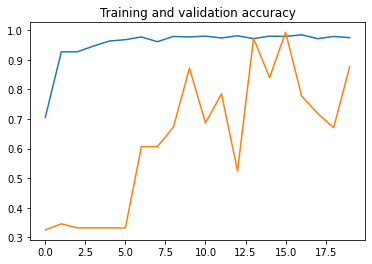

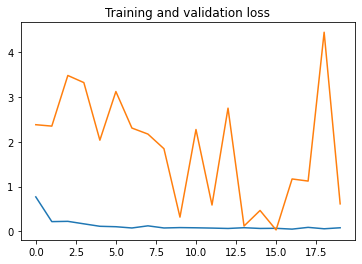

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[60, 40, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 2 + [128] * 2 + [256] * 2 + [512] * 2:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(3, activation="softmax"))

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=20, validation_data=validation_generator)
## Plotting the performance of the model ####

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
## Training and Validation Accuracy
epochs   = range(len(acc))
plt.plot  (epochs, acc)
plt.plot  (epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()
## Training and Validation loss
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss')

let us add performance scheduling

In [14]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.000001)

Epoch 1/25
55/55 [==============================] - 6s 107ms/step - loss: 0.1693 - accuracy: 0.9555 - val_loss: 1.0096 - val_accuracy: 0.7162
Epoch 2/25
55/55 [==============================] - 6s 101ms/step - loss: 0.1235 - accuracy: 0.9634 - val_loss: 1.0983 - val_accuracy: 0.8146
Epoch 3/25
55/55 [==============================] - 6s 101ms/step - loss: 0.0708 - accuracy: 0.9766 - val_loss: 43.7351 - val_accuracy: 0.3318
Epoch 4/25
55/55 [==============================] - 6s 103ms/step - loss: 0.0791 - accuracy: 0.9754 - val_loss: 4.8629 - val_accuracy: 0.6407
Epoch 5/25
55/55 [==============================] - 6s 102ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 0.7129 - val_accuracy: 0.8238
Epoch 6/25
55/55 [==============================] - 6s 101ms/step - loss: 0.0530 - accuracy: 0.9823 - val_loss: 0.5176 - val_accuracy: 0.8764
Epoch 7/25
55/55 [==============================] - 6s 101ms/step - loss: 0.0349 - accuracy: 0.9903 - val_loss: 0.6357 - val_accuracy: 0.8215
Epoch

Text(0.5, 1.0, 'Training and validation loss')

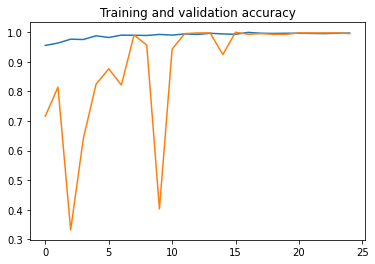

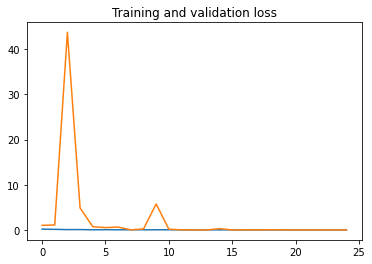

In [15]:
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[learning_rate_reduction])
## Plotting the performance of the model ####

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
## Training and Validation Accuracy
epochs   = range(len(acc))
plt.plot  (epochs, acc)
plt.plot  (epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()
## Training and Validation loss
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss')

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)